In [1]:
import rasterio
import glob
import os

import numpy as np
import geopandas as geopd
import matplotlib.pyplot as plt

from rasterio.features import sieve
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap

plt.rcParams['figure.dpi'] = 300

In [23]:
pred_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/older"
slope_filter_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/older slope filtered" 
removed_parts_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/older removed parts"

slope_path = "/home/iiro/980/GIS980/korkeusmalli_10_m/slope10m.tif"

paths = []
for path in glob.glob(os.path.join(pred_dir, "*.tif"), recursive=False):
        paths.append(path)
        
for path in paths:
    basename = os.path.basename(path)
    slope_filter_path = os.path.join(slope_filter_dir, basename)
    removed_parts_path = os.path.join(removed_parts_dir, basename)
    with rasterio.open(path) as src:
        prediction = src.read(1)
        meta = src.meta.copy()
        mask = src.read_masks(1)
        W, S, E, N = src.bounds
        
    with rasterio.open(slope_path) as slope_src:
        window = from_bounds(left=W, bottom=S, right=E, top=N, transform=slope_src.transform)
        slope = slope_src.read((1),boundless=True, window=window,out_shape=prediction.shape, resampling=Resampling.bilinear)
    
    # With these values areas with too high slope can just be multiplied away when too high slope values are encountered
    categorical_slope = np.where(slope < 5, 1, 0).astype('uint8')
    
    # Setting too steep parts to 0 (background)
    flat_prediction = categorical_slope * prediction
    
    # Returning the parts of fields that were removed
    field_correction = np.where(prediction == 1, 1, flat_prediction) 
    
    # Setting nodata back to correct value
    nodata_correction = np.where(prediction == 255, 255, field_correction)
    
    # The resulting areas may be too small, minimum feature size of 11*11 pixels (18,6 x 18,6 meters) is required
    sieved = sieve(nodata_correction, size=13**2)
    
    # Background is returned to non-sieved shape
    background_correction = np.where(nodata_correction == 0, 0, sieved)
    
    # Stupidly, rasterio needs the band count inculded in the shape, even if it is just one 
    final_image = np.expand_dims(background_correction, 0)
    
    with rasterio.open(slope_filter_path, 'w', **meta, compress='ZSTD') as dest:
        dest.write(final_image)
    
    # The removed parts are also saved for inspection
    removed_parts = prediction - background_correction
    
    # Adding nodata back to removed parts
    removed_parts = np.where(prediction==255, 255, removed_parts)
    
    final_removed = np.expand_dims(removed_parts, 0)
    
    with rasterio.open(removed_parts_path, 'w', **meta, compress='ZSTD') as removed_dest:
        removed_dest.write(final_removed)

(6173, 6173)


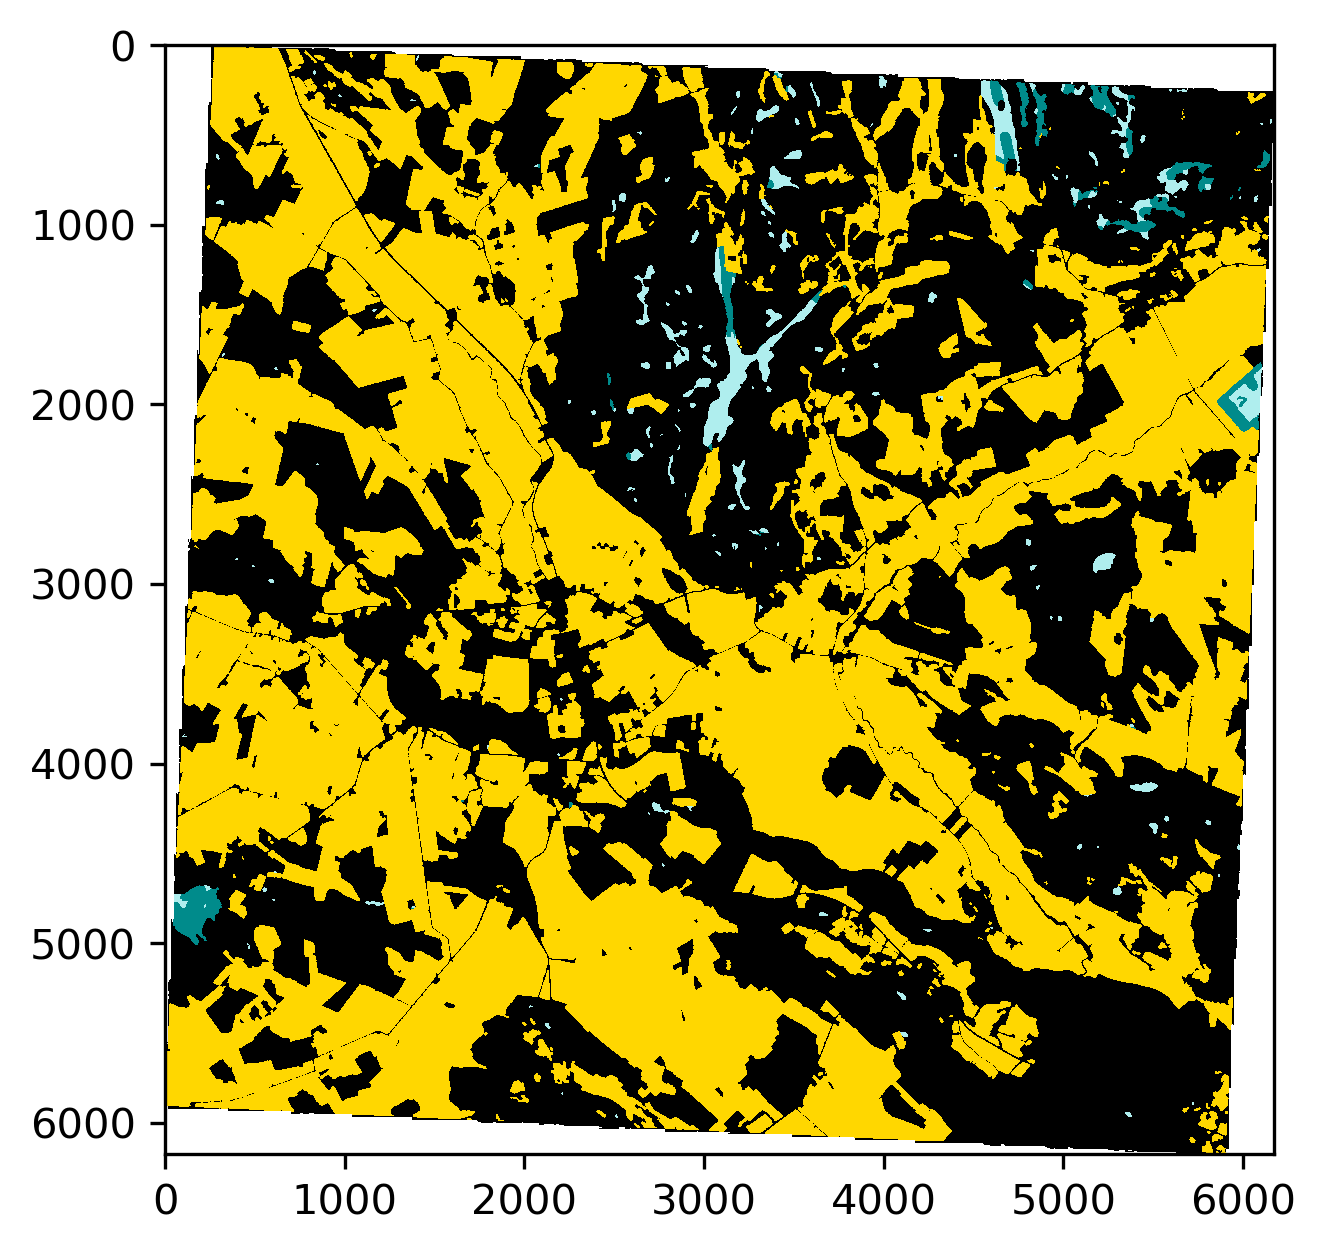

In [3]:
print(prediction.shape)
label_cmap=ListedColormap(['black', 'gold', 'darkcyan', 'paleturquoise', 'white'])
plt.imshow(prediction, interpolation='none', cmap=label_cmap, vmax=4)
plt.show()

(6173, 6173)


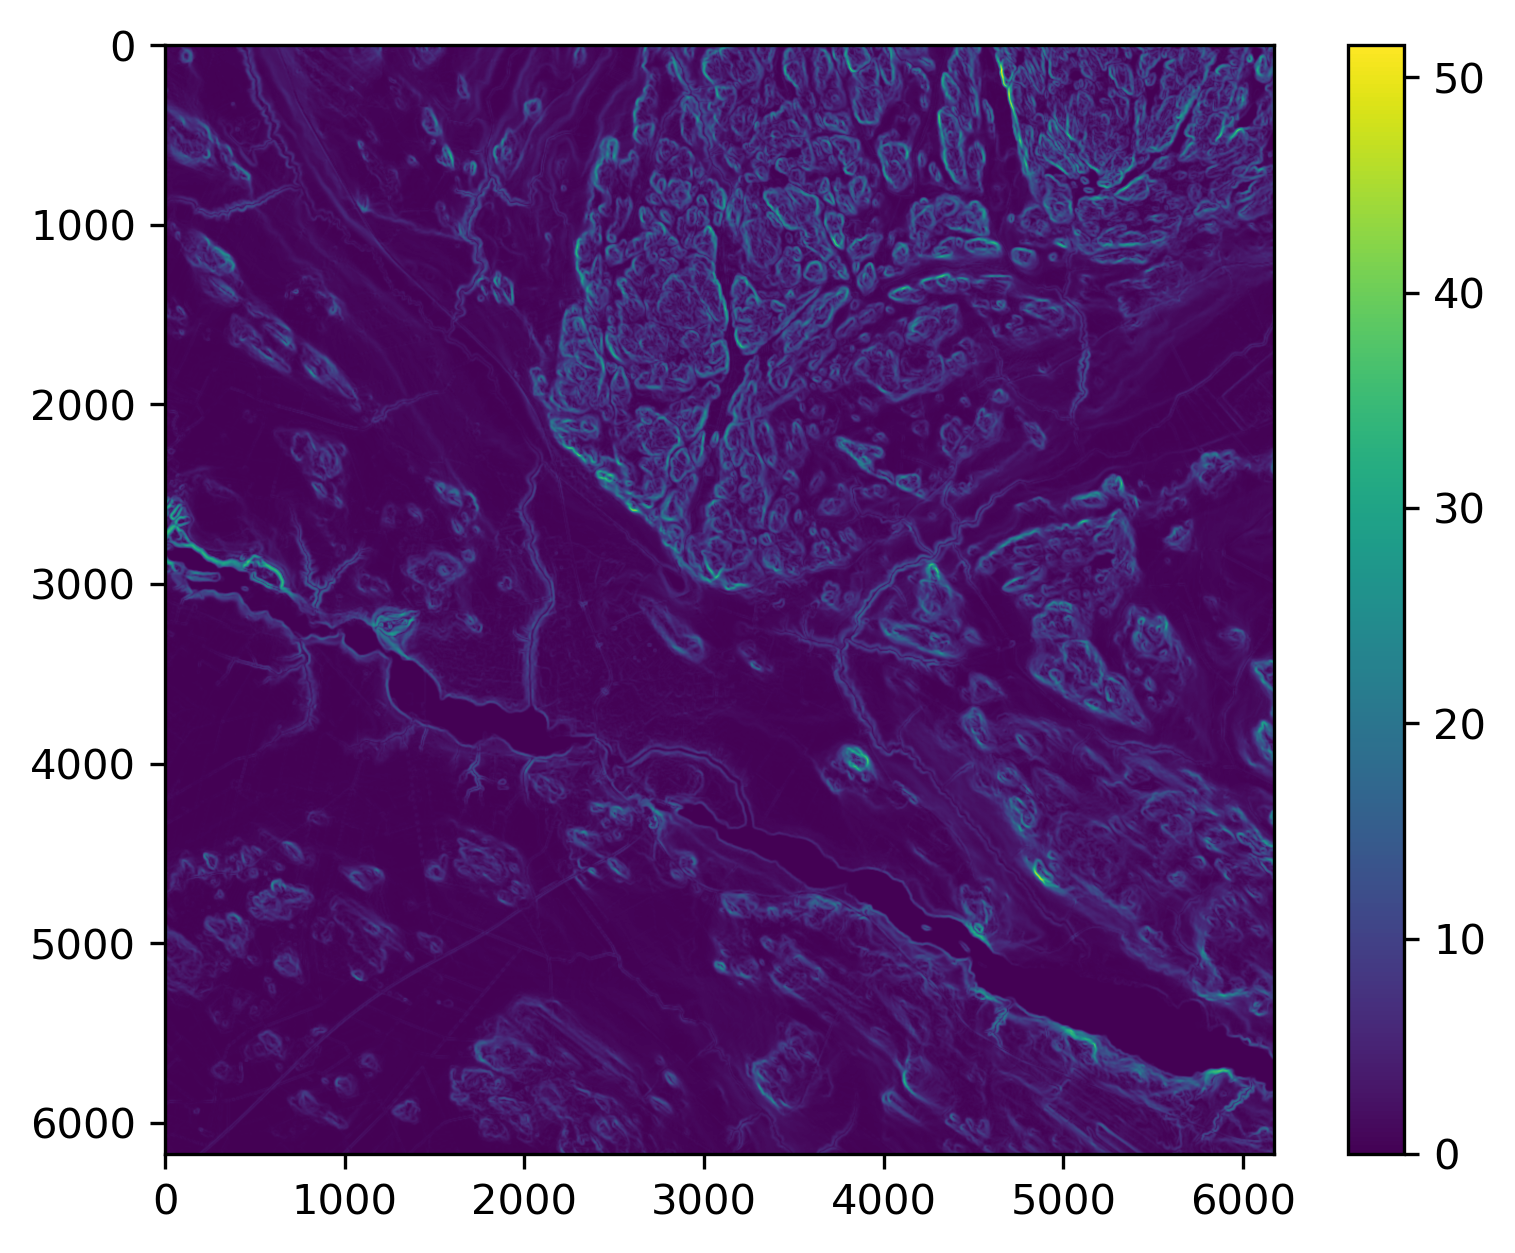

In [4]:
print(slope.shape)
plt.imshow(slope)
plt.colorbar()
plt.show()

(6173, 6173)


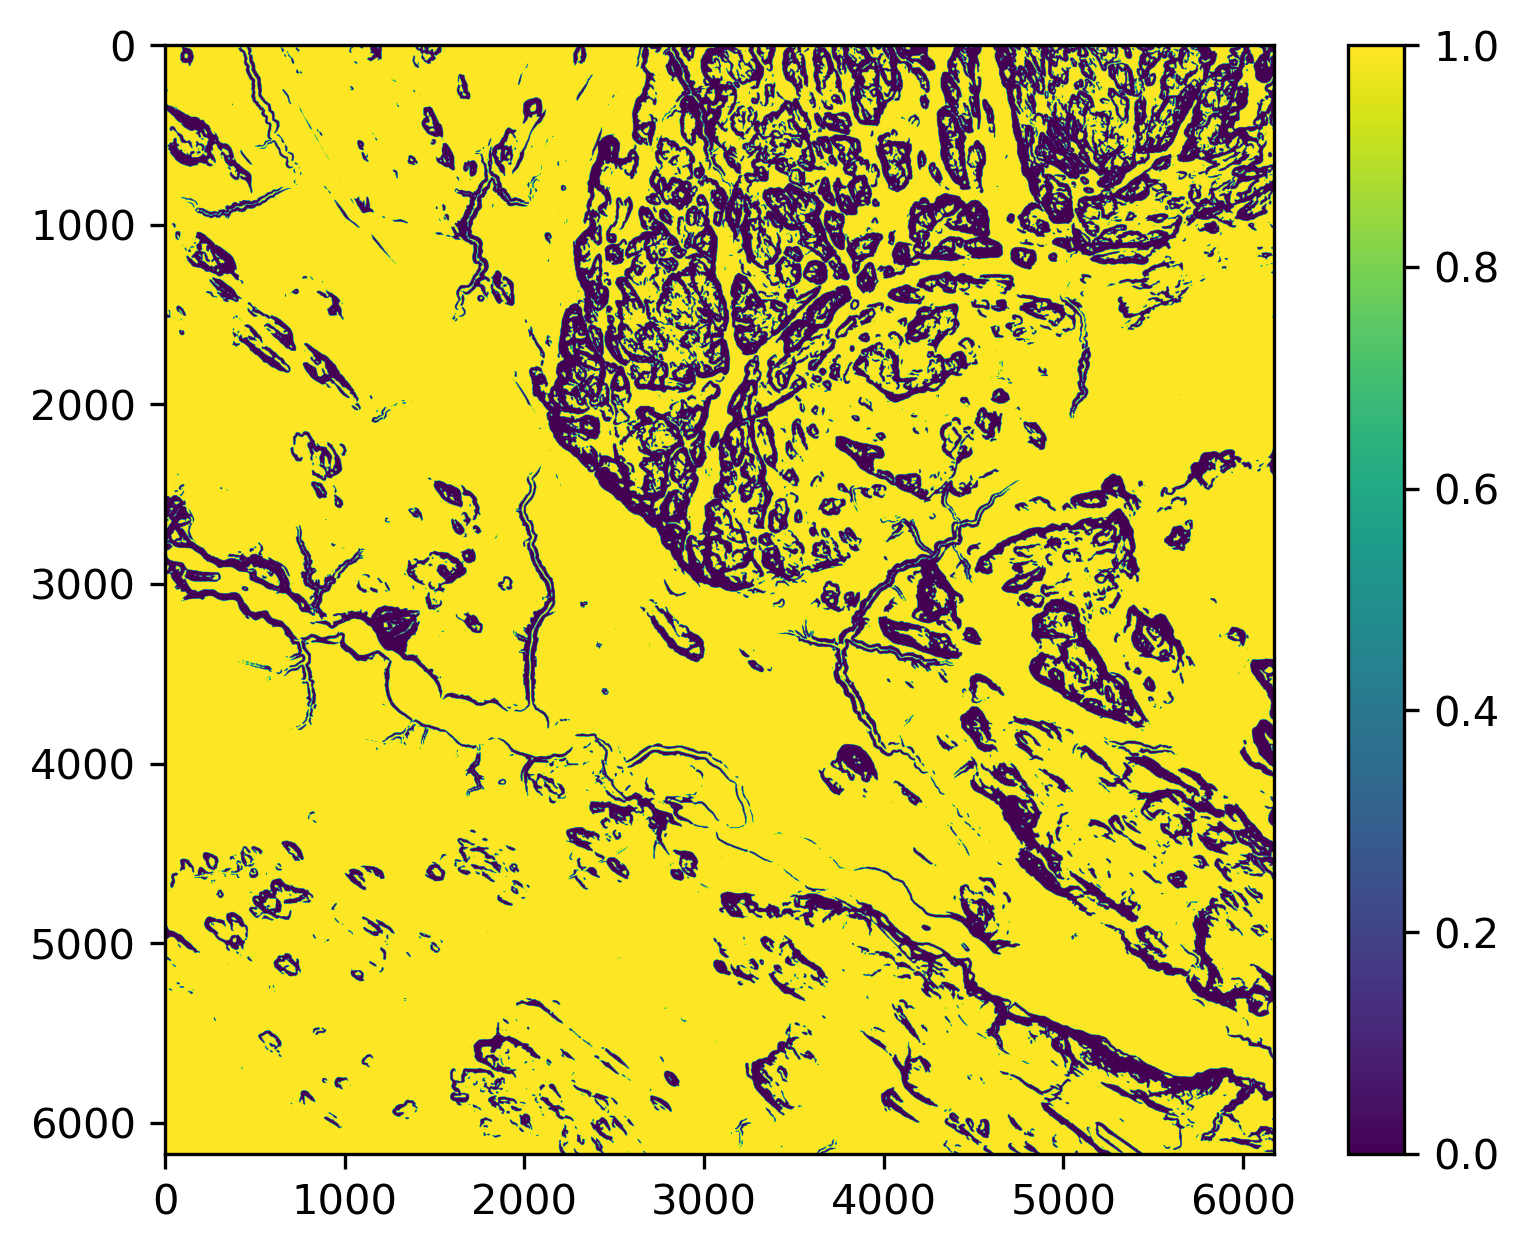

In [5]:
print(categorical_slope.shape)
plt.imshow(categorical_slope)
plt.colorbar()
plt.show()

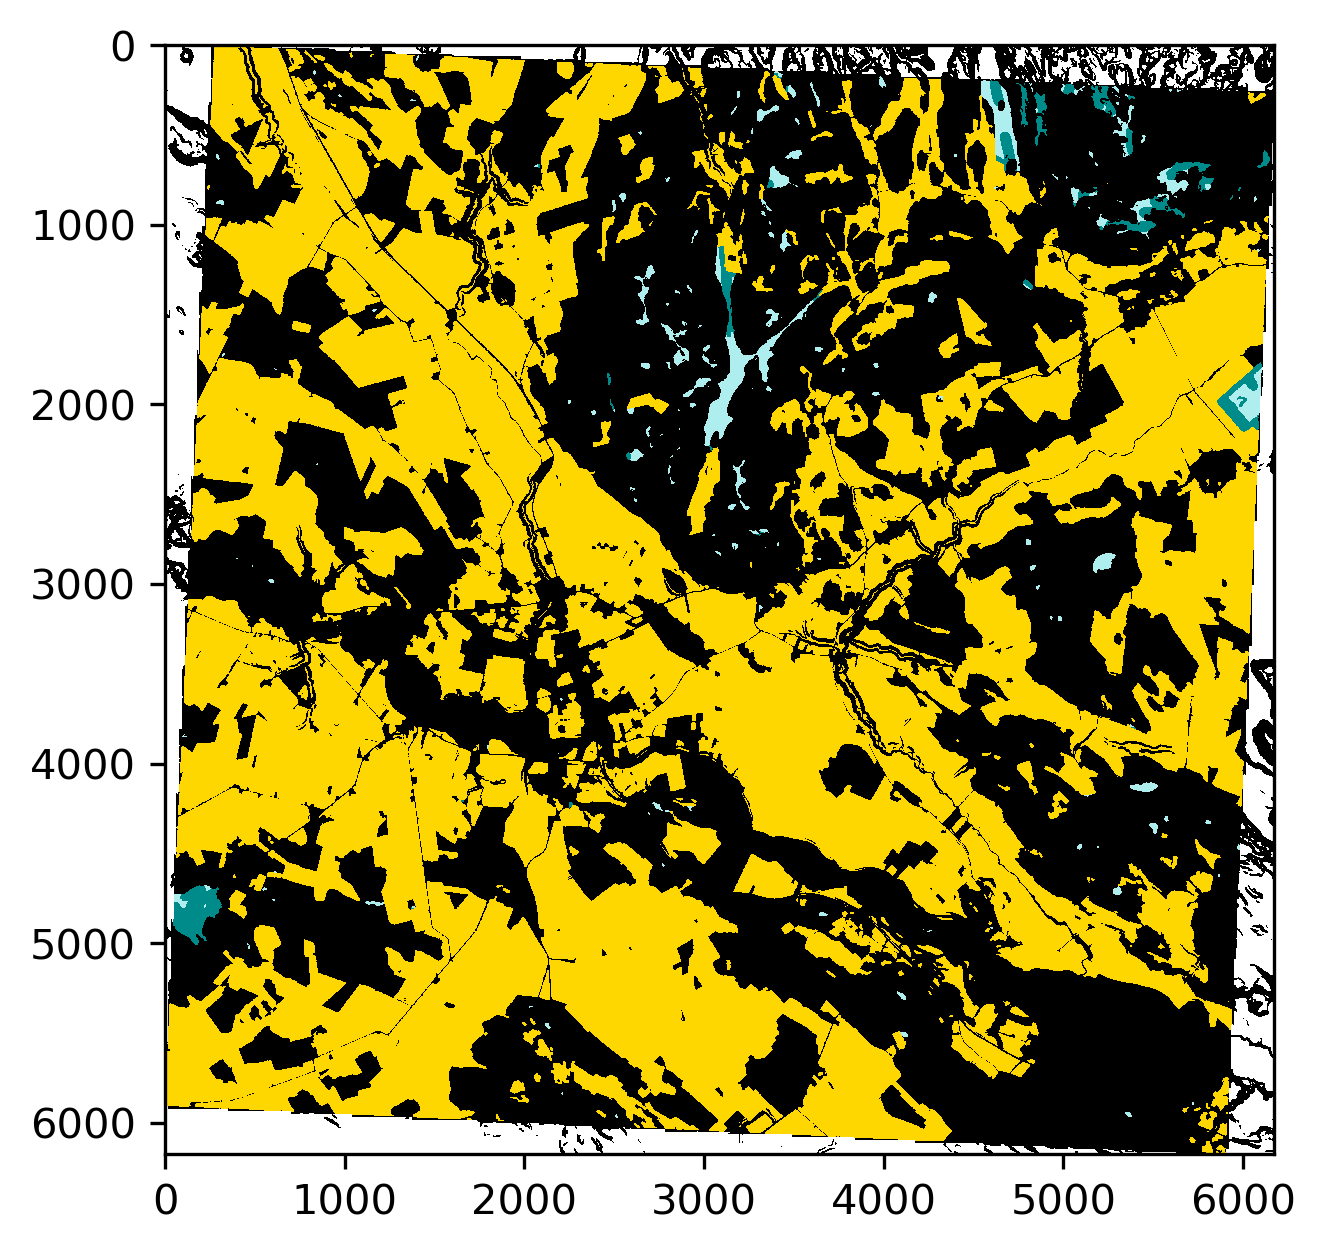

In [6]:
plt.imshow(flat_prediction, interpolation='none', cmap=label_cmap, vmax=4)
plt.show()

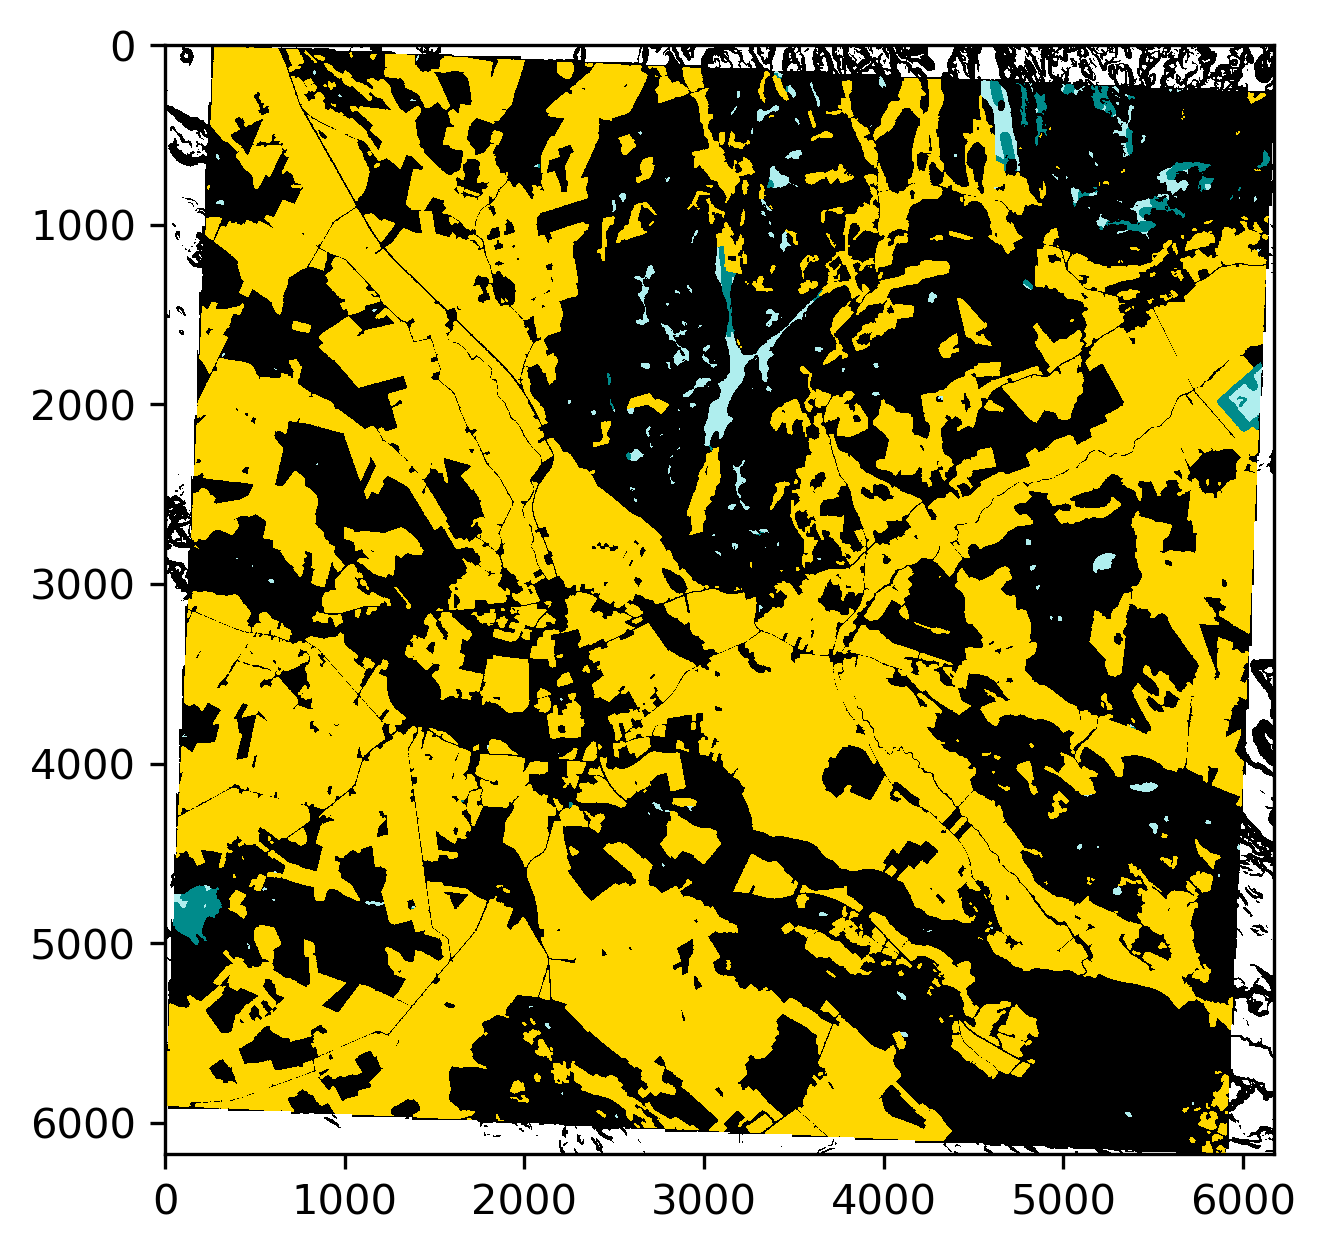

In [7]:
plt.imshow(field_correction, interpolation='none', cmap=label_cmap, vmax=4)
plt.show()

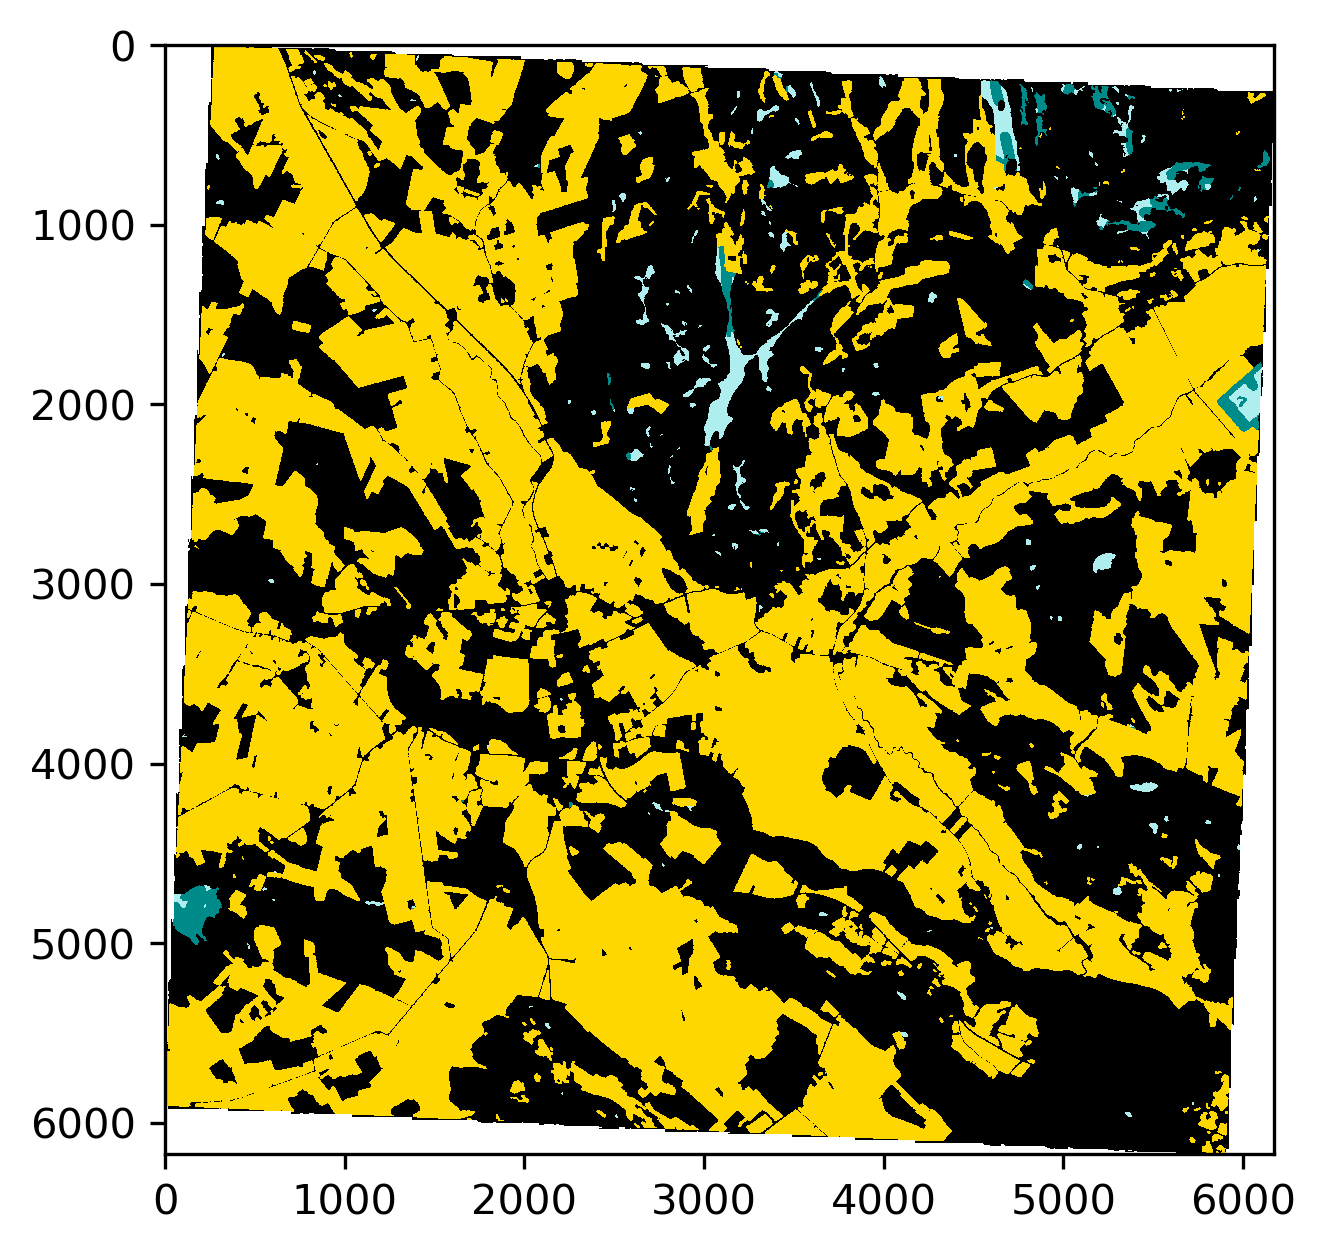

In [8]:
plt.imshow(background_correction, interpolation='none', cmap=label_cmap, vmax=4)
plt.show()

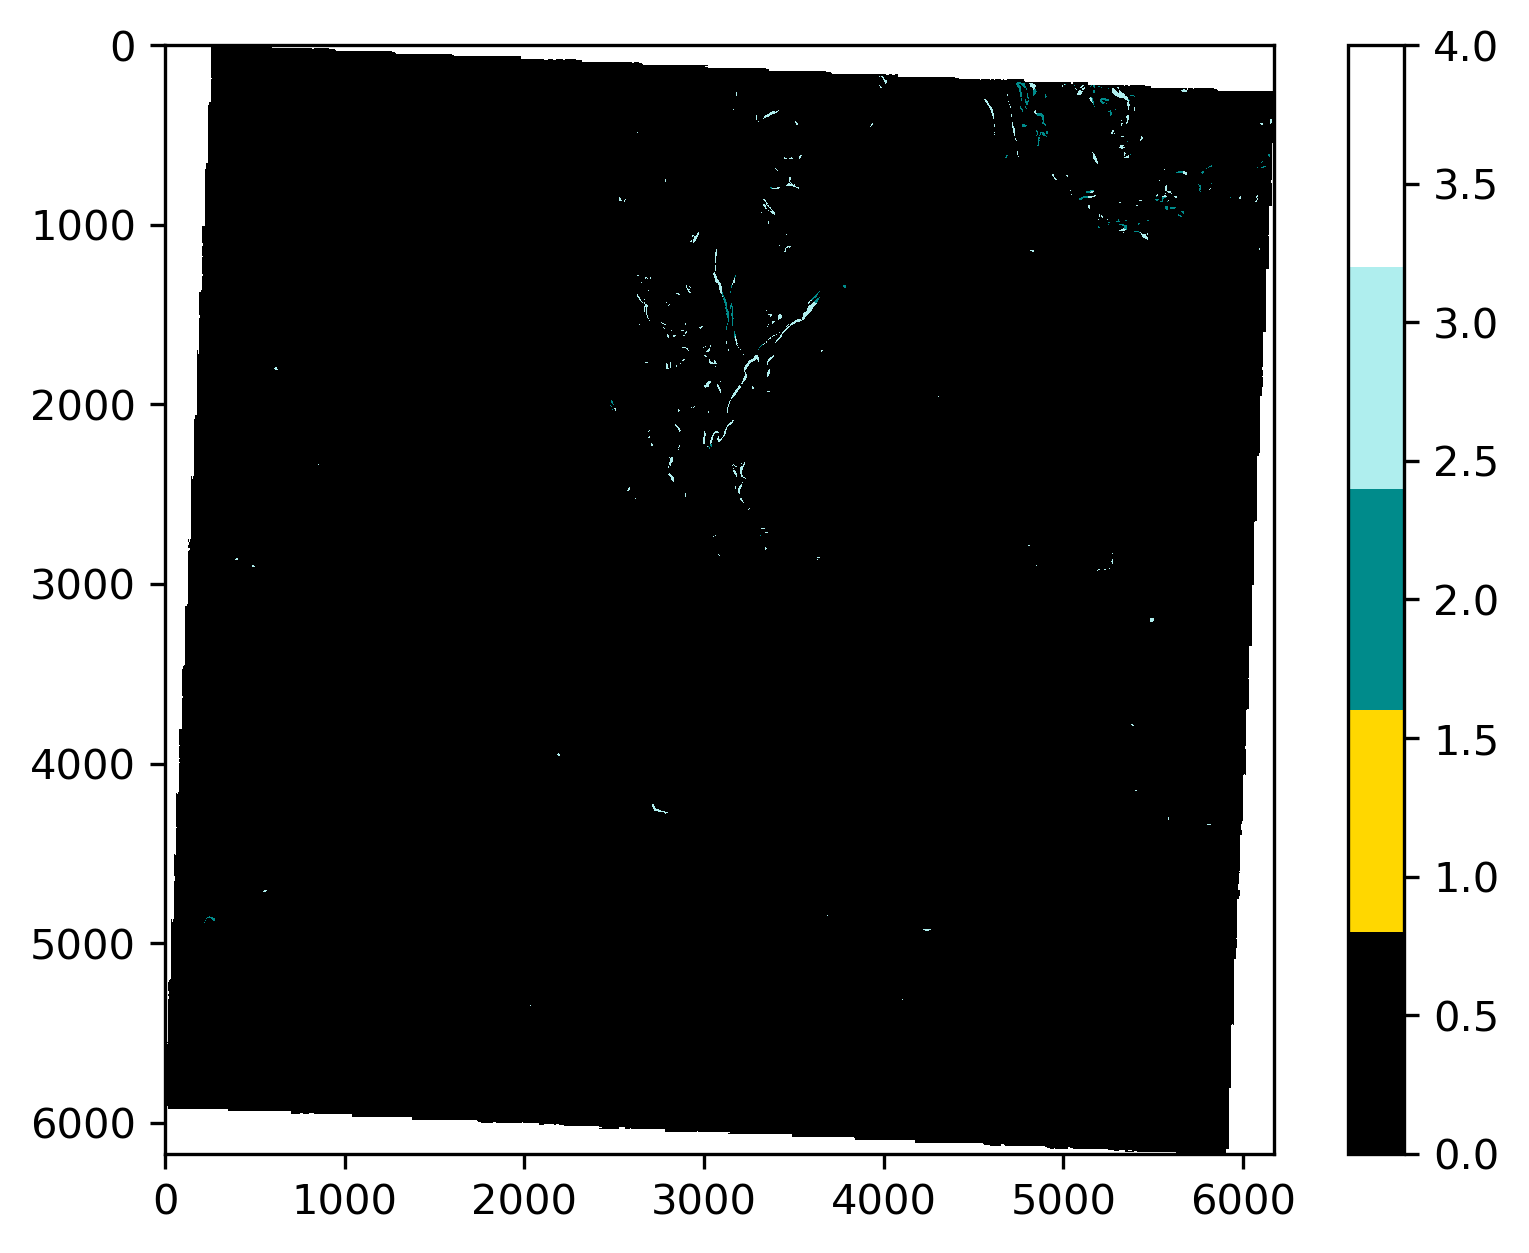

In [9]:
plt.imshow(removed_parts, interpolation='none', cmap=label_cmap, vmax=4)
plt.colorbar()
plt.show()

In [10]:
print(meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 6173, 'height': 6173, 'count': 1, 'crs': CRS.from_epsg(3067), 'transform': Affine(1.6922325460982264, 0.0, 305549.689709389,
       0.0, -1.6922325342246367, 6732286.440611024)}


In [38]:
print(len(paths))

2722


In [12]:
print(slope_filter_path)

/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/newer slope filtered/202405_1959.tif
